In [161]:
# Import realsense python wrapper
import os
import cv2
import json
import shutil
import sys
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
import pyrealsense2 as rs 
print("Environment Ready")

Environment Ready


## Bag and JSON with coordinates path

In [35]:
RECORDING_PATH = '../dataset/bags/cart_3_red_yellow.bag'
MASK_PATH = '../src/Mask_RCNN/datasets/process'

##  1. Open Recording

In [36]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(RECORDING_PATH)
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
# Frame 300 has 2 peppers with peduncles
for x in range(300):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


## Get RGB data

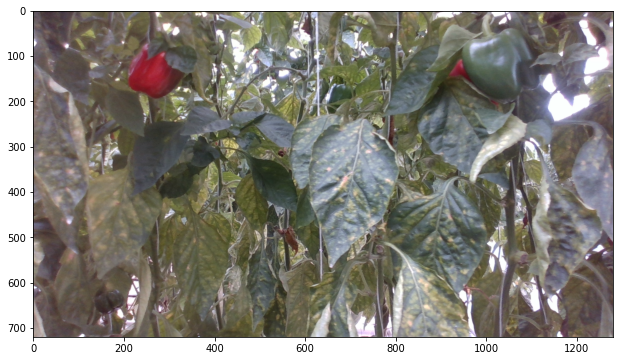

In [37]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

# Get Depth

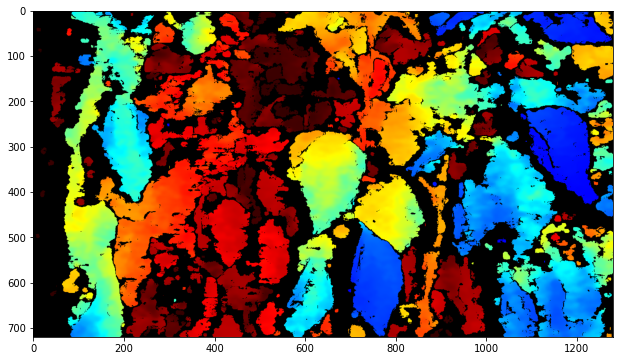

In [38]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

## Align Depth with color

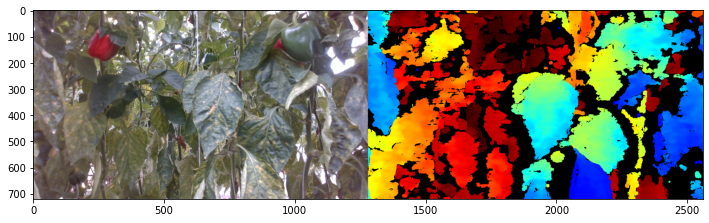

In [39]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

## Save one frame of the recording for inference

In [40]:
im = Image.fromarray(color)
im.save(os.path.join(MASK_PATH + '/frame.png'))
shutil.move(MASK_PATH + '/frame.png', MASK_PATH + '/input/frame.png')

'../src/Mask_RCNN/datasets/process/input/frame.png'

## Reading bounding boxes from json

In [41]:
file_names = next(os.walk(MASK_PATH + '/boxes'))[2]
file_name = file_names[0]
data = []
with open(os.path.join(MASK_PATH + '/boxes/', file_name)) as json_file:
    data = json.load(json_file)
    data = np.array(data, dtype=object)

In [42]:
tmp_img = color.copy()

### Draw bounding boxes read from JSON

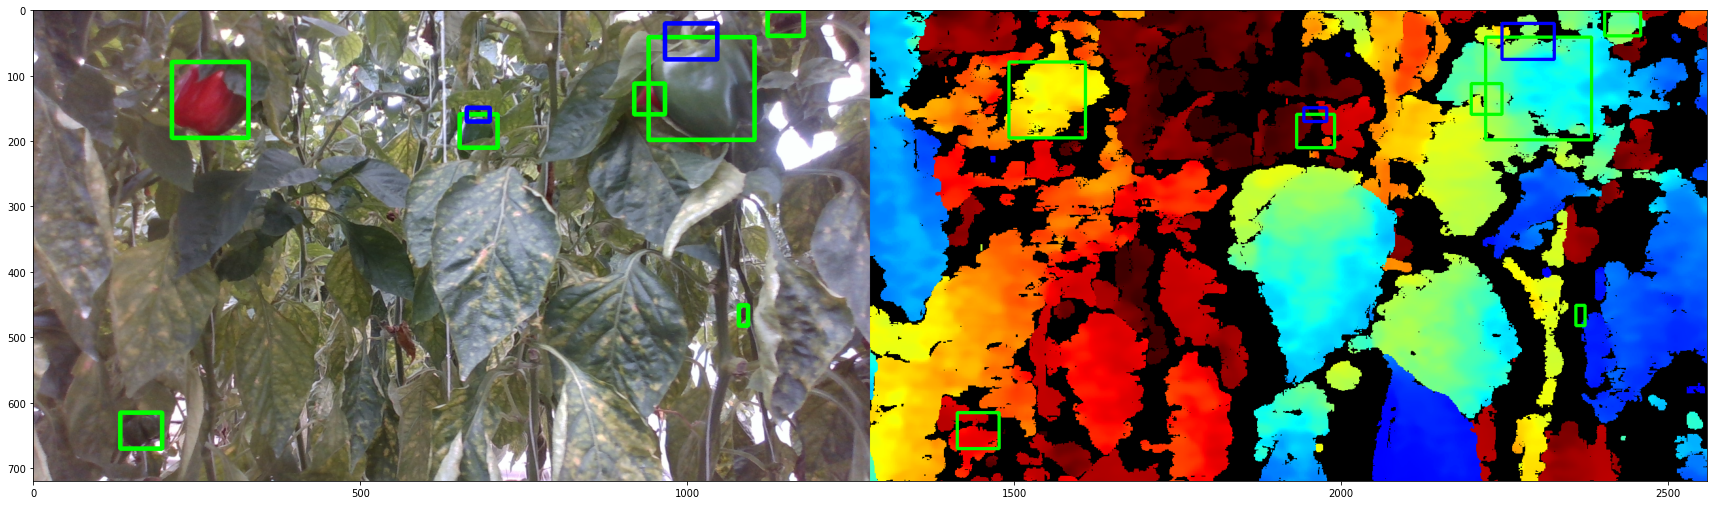

In [43]:
expected = 1 # Scale multiplier, in this case the coordinates are already alligned
xmin = []
ymin = []
xmax = []
ymax = []

for box in data:
    xmin = box[0][1] 
    ymin = box[0][0] 
    xmax = box[0][3] 
    ymax = box[0][2]
    xmin_depth = int((xmin * expected ) )
    ymin_depth = int((ymin * expected) )
    xmax_depth = int((xmax * expected ) )
    ymax_depth = int((ymax * expected) )
    # box[1] == 1: fruit
    # box[1] == 2: peduncle
    if box[1] == 1:
        cv2.rectangle(tmp_img, (int(xmin * expected), int(ymin * expected)), (int(xmax * expected), int(ymax * expected)), (0, 255, 0), 5)
        cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), (xmax_depth, ymax_depth), (0, 255, 0), 3)
    else:
        cv2.rectangle(tmp_img, (int(xmin * expected), int(ymin * expected)), (int(xmax * expected), int(ymax * expected)), (0, 0, 255), 5)
        cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), (xmax_depth, ymax_depth), (0, 0, 255), 3)

images = np.hstack((tmp_img, colorized_depth))
plt.figure(figsize = (30,60))
plt.imshow(images)

# Get Coordinates

In [44]:
# Get Depth data from the sensor 
depth           = np.asanyarray(aligned_depth_frame.get_data())
# Get data scale from the device and convert to meters
depth_scale     = profile.get_device().first_depth_sensor().get_depth_scale()
# Get intinsic values od alligned depth frame
depth_intrin    = aligned_depth_frame.profile.as_video_stream_profile().intrinsics

expected = 1 # Scale multiplier, in this case the coordinates are already alligned

for box in data:
    xmin = box[0][1] 
    ymin = box[0][0] 
    xmax = box[0][3] 
    ymax = box[0][2]
    xmin_depth = int((xmin * expected))
    ymin_depth = int((ymin * expected))
    xmax_depth = int((xmax * expected))
    ymax_depth = int((ymax * expected))
    
    # Get depth values at the bbox location
    bbox_area_depth = depth[ymin_depth:ymax_depth,  xmin_depth:xmax_depth]
    # Obtain average depth value, this will be used to obtain the centroid coordinates
    bbox_centroid_pixel_depth_value,_,_,_ = cv2.mean(bbox_area_depth)

    # Get the centroid of the bbox
    bbox_center = [
        int((xmax_depth - xmin_depth)/2 + xmin_depth),
        int((ymax_depth - ymin_depth)/2 + ymin_depth)
    ]
    
    coordinates = rs.rs2_deproject_pixel_to_point(depth_intrin, bbox_center, bbox_centroid_pixel_depth_value * depth_scale)
    print(" X: {} Y: {} Z:{}".format(coordinates[0], coordinates[1], coordinates[2]))

 X: 0.2010759711265564 Y: -0.12954553961753845 Z:0.47864893078804016
 X: -0.19702716171741486 Y: -0.12403911352157593 Z:0.49407967925071716
 X: 0.024765007197856903 Y: -0.10149836540222168 Z:0.5077975392341614
 X: -0.2835403084754944 Y: 0.16509585082530975 Z:0.552588939666748
 X: 0.14604385197162628 Y: -0.12659287452697754 Z:0.3626904785633087
 X: 0.0159935113042593 Y: 0.003498848294839263 Z:0.032654378563165665
 X: 0.17275020480155945 Y: -0.13137610256671906 Z:0.5188049077987671
 X: 0.25921690464019775 Y: -0.1753378063440323 Z:0.4633239507675171
 X: 0.02445914037525654 Y: -0.11649682372808456 Z:0.5129796266555786


## Get Z (depth from sensor)

For debugging only, value should match z value calculated above

In [45]:
# # Get Depth data from the sensor and crop to the pepper section
# depth = np.asanyarray(aligned_depth_frame.get_data())
# depth_area = depth[ymin_depth:ymax_depth,  xmin_depth:xmax_depth]
# #depth_area.shape

# # Get data scale from the device and convert to meters
# depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
# depth = depth_area * depth_scale
# dist,_,_,_ = cv2.mean(depth)
# print("Detected a pepper {} meters away.".format(dist))

# Filter Peppers
They should already be ordered by size

In [31]:
def validate_size(x_coords, y_coords, threshold):
    if (x_coords[1] - x_coords[0]) * (y_coords[1] - y_coords[0]) > (threshold**2):
        return True
    else:
        return False

In [107]:
pepper_data = []
peduncle_data = []
BBOX_SIZE_THRESHOLD = 100

for box in data:
    box = box.tolist()
    xmin = box[0][1]
    xmax = box[0][3]
    ymin = box[0][0]
    ymax = box[0][2]

    bbox_center = [
        int((xmax - xmin)/2 + xmin),
        int((ymax - ymin)/2 + ymin)
    ]

    if(validate_size([xmin, xmax], [ymin, ymax], BBOX_SIZE_THRESHOLD)):
        box.append(bbox_center)
        pepper_data.append(box)
    
    # Append data from peduncles
    if(box[1] == 2):
        bbox_center = [
            int((xmax - xmin)/2 + xmin),
            int((ymax - ymin)/2 + ymin)
        ]
        
        box.append(bbox_center)
        peduncle_data.append(box)

print("{} peppers were filtered, only {} will be processed for coordinates and orientation".format(len(data) - len(pepper_data), len(pepper_data)))

7 peppers were filterd, only 2 will be processed for coordinates and orientation


# Find Peduncle

In [276]:
def get_orientation(pepper_center, peduncle_center):
    pepper_x = pepper_center[0]
    pepper_y = pepper_center[1]
    peduncle_x = peduncle_center[0]
    peduncle_y = peduncle_center[1]
    radians = math.atan2(peduncle_y - pepper_y, peduncle_x - pepper_x)
    # radians = math.atan2(pepper_y - peduncle_y, pepper_x - peduncle_x)
    return math.degrees(radians)

In [278]:
final_pepper_list = {}

for count, pepper in enumerate(pepper_data):
    xmin = pepper[0][1]
    xmax = pepper[0][3]
    ymin = pepper[0][0]
    ymax = pepper[0][2]

    # Currently using the average size of the bbox to find peduncles near the center of the pepper
    avg_size = int(((xmax - xmin) + (ymax -ymin))/2)

    pepper_center_x = pepper[2][0]
    pepper_center_y = pepper[2][1]

    # Add pepper information to the final list
    final_pepper_list[count] = {}
    final_pepper_list[count]["pepper"] = pepper
    
    # Traverse peduncles to find one that corresponds to a pepper
    for peduncle in peduncle_data:
        peduncle_center_x = peduncle[2][0]
        peduncle_center_y = peduncle[2][1]
        
        if(pepper_center_x + avg_size >  peduncle_center_x and pepper_center_x - avg_size   < peduncle_center_x):
            if(pepper_center_y + avg_size >  peduncle_center_y and pepper_center_y - avg_size   < peduncle_center_y):
                # print("Found pepper {} with peduncle {}".format(pepper[2], peduncle[2]))
                final_pepper_list[count]["peduncle"]    = peduncle
                final_pepper_list[count]["angle"]       = get_orientation(pepper[2], peduncle[2])

final_pepper_list

{0: {'pepper': [[41, 941, 198, 1103], 1, [1022, 119]],
  'peduncle': [[20, 966, 75, 1046], 2, [1006, 47]],
  'angle': -102.52880770915151},
 1: {'pepper': [[79, 212, 195, 329], 1, [270, 137]]}}

In [237]:
tmp1_img = color.copy()

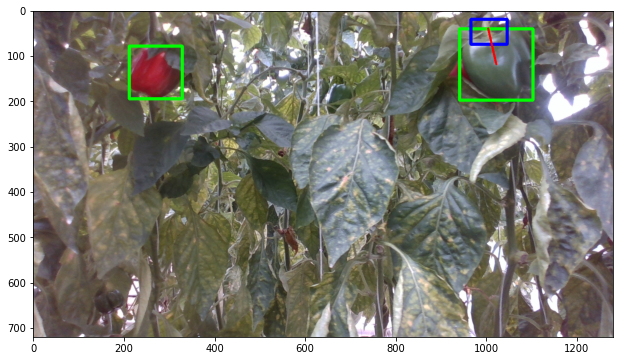

In [282]:
tmp1_img = color.copy()
for key, value in final_pepper_list.items():
    xmin = value["pepper"][0][1]
    xmax = value["pepper"][0][3]
    ymin = value["pepper"][0][0]
    ymax = value["pepper"][0][2]
    cv2.rectangle(tmp1_img, (int(xmin * expected), int(ymin * expected)), (int(xmax * expected), int(ymax * expected)), (0, 255, 0), 5)

    if "peduncle" in value:
        xmin = value["peduncle"][0][1]
        xmax = value["peduncle"][0][3]
        ymin = value["peduncle"][0][0]
        ymax = value["peduncle"][0][2]

        # Draw peduncle
        cv2.rectangle(tmp1_img, (int(xmin * expected), int(ymin * expected)), (int(xmax * expected), int(ymax * expected)), (0, 0, 255), 5)

        # Draw line with computed angle
        angle = value["angle"]
        length = 80

        p1 = value["pepper"][2]
        p2_x = int(p1[0] + length * math.cos(angle * math.pi /180))
        p2_y = int(p1[1] + length * math.sin(angle * math.pi /180))

        cv2.line(tmp1_img, p1, (p2_x, p2_y), (255, 0, 0), 3)
        
plt.imshow(tmp1_img)

In [283]:
final_pepper_list

{0: {'pepper': [[41, 941, 198, 1103], 1, [1022, 119]],
  'peduncle': [[20, 966, 75, 1046], 2, [1006, 47]],
  'angle': -102.52880770915151},
 1: {'pepper': [[79, 212, 195, 329], 1, [270, 137]]}}